In [ ]:
#set a seed so that if the script is kept consistent, the result will always be the same. 
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# If GPU available...
if torch.cuda.is_available():   
    torch.cuda.empty_cache() #clearing the cache 
    # use the GPU.   
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If GPU not available
else:
    print('GPU not available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
dataset= {"labels" : ['AGAINST','FAVOR','NEUTRAL'],
          "label_count": 3}

dataset1 = {
    "name":"E-USA",
    "train_path":"data/E-USA/train.csv",
    "test_path":"data/E-USA/test.csv",
    "labels":['AGAINST','FAVOR','NEUTRAL']
}

dataset2 = {
    "name":"R-CAT",
    "train_path_sp":"data/R-CAT/spanish_train.csv",
    "train_path_ca":"data/R-CAT/catalan_train.csv",
    "val_path_sp":"data/R-CAT/spanish_val.csv",
    "val_path_ca":"data/R-CAT/catalan_val.csv",
    "test_path_sp":"data/R-CAT/spanish_test.csv",
    "test_path_ca":"data/R-CAT/catalan_test.csv",
    "labels":['AGAINST','FAVOR','NEUTRAL']
}

dataset3 = {
    "name": "E-FRA",
    "lepen_path":"data/E-FRA/lepen_fr.csv",
    "macron_path":"data/E-FRA/macron_fr.csv",
    "labels" : ['AGAINST','FAVOR','NEUTRAL']
}

dataset4 = {
    "name": "R-ITA",
    "path":"data/R-ITA/referendum_it.csv",
    "labels" : ['AGAINST','FAVOR','NEUTRAL']
}

In [ ]:
def read_dataset1():
    train = pd.read_csv(dataset1['train_path'], encoding = 'unicode_escape')
    train['Language']='EN'
    test = pd.read_csv(dataset1['test_path'], encoding = 'unicode_escape')
    test['Language']='EN'

    data = [train,test]
    data = pd.concat(data)
    data = data.loc[(data['Target']=='Hillary Clinton') | (data['Target']=='Donald Trump')]
    data['Type'] = 'Election'
    data.loc[data['Stance']=='NONE', 'Stance']='NEUTRAL'
    data.drop('Opinion Towards', inplace=True, axis=1)
    data.drop('Sentiment', inplace=True, axis=1) 
    return data


def read_dataset2():
    spanish_train = pd.read_csv(dataset2['train_path_sp'], 
                            dtype={'id_str': 'str'}, sep='\t', encoding="utf-8")
    spanish_train['Language']='SP'
    catalan_train = pd.read_csv(dataset2['train_path_ca'], 
                            dtype={'id_str': 'str'}, sep='\t', encoding="utf-8")
    catalan_train['Language']='CA'
    spanish_val = pd.read_csv(dataset2['val_path_sp'], 
                            dtype={'id_str': 'str'}, sep='\t', encoding="utf-8")
    spanish_val['Language']='SP'
    catalan_val = pd.read_csv(dataset2['val_path_ca'], 
                            dtype={'id_str': 'str'}, sep='\t', encoding="utf-8")
    catalan_val['Language']='CA'
    spanish_test = pd.read_csv(dataset2['test_path_sp'], 
                            dtype={'id_str': 'str'}, sep='\t', encoding="utf-8")
    spanish_test['Language']='SP'
    catalan_test = pd.read_csv(dataset2['test_path_ca'], 
                            dtype={'id_str': 'str'}, sep='\t', encoding="utf-8")
    catalan_test['Language']='CA'

    data = [spanish_train,catalan_train,spanish_val,catalan_val,spanish_test,catalan_test]
    data = pd.concat(data)
    data['Type'] = 'Referendum'
    data['Target'] = 'Catalonian Independence'
    data.drop('id_str', inplace=True, axis=1)
    data = data.rename(columns={'TWEET': 'Tweet', 'LABEL': 'Stance'})
    data = data.sample(frac=1).reset_index(drop=True)

    data_tmp = data.loc[(data['Stance']=='AGAINST') & (data['Language']=='SP')].head(2231)
    data_tmp = data_tmp.append(data.loc[(data['Stance']=='NEUTRAL') & (data['Language']=='SP')].head(1215))
    data_tmp = data_tmp.append(data.loc[(data['Stance']=='FAVOR') & (data['Language']=='SP')].head(2099))
    data_tmp = data_tmp.append(data.loc[(data['Stance']=='AGAINST') & (data['Language']=='CA')].head(149))
    data_tmp = data_tmp.append(data.loc[(data['Stance']=='NEUTRAL') & (data['Language']=='CA')].head(598))
    data_tmp = data_tmp.append(data.loc[(data['Stance']=='FAVOR') & (data['Language']=='CA')].head(5106))
    return data_tmp

def read_dataset3():
    fr_lepen = pd.read_csv(dataset3['lepen_path'])
    fr_lepen['Language']='FR'
    fr_lepen['Target'] = 'Marine Le Pen'

    fr_macron = pd.read_csv(dataset3['macron_path'])
    fr_macron['Language']='FR'
    fr_macron['Target'] = 'Emmanuel Macron'

    data = [fr_lepen,fr_macron]
    data = pd.concat(data)
    data['Type'] = 'Election'
    data.drop('id', inplace=True, axis=1)
    data.drop('Set', inplace=True, axis=1)
    data.drop('screen_name', inplace=True, axis=1)
    data.drop('user_id', inplace=True, axis=1)
    data.drop('date', inplace=True, axis=1)
    data.drop('POS', inplace=True, axis=1)
    data.drop('POSplus', inplace=True, axis=1)
    data.drop('textplus', inplace=True, axis=1)
    data.loc[data['Stance']=='agains', 'Stance']='AGAINST'
    data.loc[data['Stance']=='favor', 'Stance']='FAVOR'
    data.loc[data['Stance']=='FAVOUR', 'Stance']='FAVOR'
    data.loc[data['Stance']=='NONE', 'Stance']='NEUTRAL'
    return data

def read_dataset4():
    data = pd.read_csv(dataset4['path'])
    data['Language']='IT'
    data['Type'] = 'Referendum'
    data['Target'] = 'Constitutional Reform'
    data.drop('id', inplace=True, axis=1)
    data.drop('Set', inplace=True, axis=1)
    data.drop('screen_name', inplace=True, axis=1)
    data.drop('user_id', inplace=True, axis=1)
    data.drop('date', inplace=True, axis=1)
    data.drop('POS', inplace=True, axis=1)
    data.drop('POSplus', inplace=True, axis=1)
    data.drop('textplus', inplace=True, axis=1)
    data.loc[data['Stance']=='agains', 'Stance']='AGAINST'
    data.loc[data['Stance']=='favor', 'Stance']='FAVOR'
    data.loc[data['Stance']=='none', 'Stance']='NEUTRAL'
    return data

In [ ]:
data1 = read_dataset1()
data2 = read_dataset2()
data3 = read_dataset3()
data4 = read_dataset4()

frames = [data1,data2,data3,data4]
data = pd.concat(frames)

In [ ]:
print('total number of records', len(data))
data_label = collections.Counter(data['Stance'])
print('Stance bifurcation', data_label)

data_frq1 = data.groupby(['Target','Stance']).size().reset_index()
data_frq1=data_frq1.rename(columns={0:'Count'})

data_frq1= pd.pivot_table(data=data_frq1 , index=['Target'], columns=['Stance'],values=['Count'])
data_frq1.reset_index(inplace=True)
data_frq1.columns =['Target','AGAINST','FAVOR','NEUTRAL']
data_frq1

total number of records 13834
Stance bifurcation Counter({'FAVOR': 6631, 'AGAINST': 4504, 'NEUTRAL': 2699})


,Target,AGAINST,FAVOR,NEUTRAL
0,Catalonian Independence,2380,6001,1813
1,Constitutional Reform,486,163,184
2,Donald Trump,299,148,260
3,Emmanuel Macron,308,91,131
4,Hillary Clinton,565,163,256
5,Marine Le Pen,466,65,55


In [ ]:
print('total number of records', len(data))
data_label = collections.Counter(data['Stance'])
print('Stance bifurcation', data_label)

data_frq2 = data.groupby(['Target','Language','Stance']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})

data_frq2= pd.pivot_table(data=data_frq2 , index=['Target','Language'], columns=['Stance'],values=['Count'])
data_frq2.reset_index(inplace=True)
data_frq2.columns =['Target','Language','AGAINST','FAVOR','NEUTRAL']
data_frq2

total number of records 13834
Stance bifurcation Counter({'FAVOR': 6631, 'AGAINST': 4504, 'NEUTRAL': 2699})


,Target,Language,AGAINST,FAVOR,NEUTRAL
0,Catalonian Independence,CA,149,3902,598
1,Catalonian Independence,SP,2231,2099,1215
2,Constitutional Reform,IT,486,163,184
3,Donald Trump,EN,299,148,260
4,Emmanuel Macron,FR,308,91,131
5,Hillary Clinton,EN,565,163,256
6,Marine Le Pen,FR,466,65,55


In [ ]:
print('total number of records', len(data))
data_label = collections.Counter(data['Language'])
print('Stance bifurcation', data_label)

data_frq2 = data.groupby(['Language']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})
data_frq2

total number of records 13834
Stance bifurcation Counter({'SP': 5545, 'CA': 4649, 'EN': 1691, 'FR': 1116, 'IT': 833})


,Language,Count
0,CA,4649
1,EN,1691
2,FR,1116
3,IT,833
4,SP,5545


In [ ]:
print('total number of records', len(data))
data_label = collections.Counter(data['Stance'])
print('Stance bifurcation', data_label)

data_frq3 = data.groupby(['Language','Stance']).size().reset_index()
data_frq3=data_frq3.rename(columns={0:'Count'})

data_frq3= pd.pivot_table(data=data_frq3 , index=['Language'], columns=['Stance'],values=['Count'])
data_frq3.reset_index(inplace=True)
data_frq3.columns =['Language','AGAINST','FAVOR','NEUTRAL']
data_frq3

total number of records 13834
Stance bifurcation Counter({'FAVOR': 6631, 'AGAINST': 4504, 'NEUTRAL': 2699})


,Language,AGAINST,FAVOR,NEUTRAL
0,CA,149,3902,598
1,EN,864,311,516
2,FR,774,156,186
3,IT,486,163,184
4,SP,2231,2099,1215


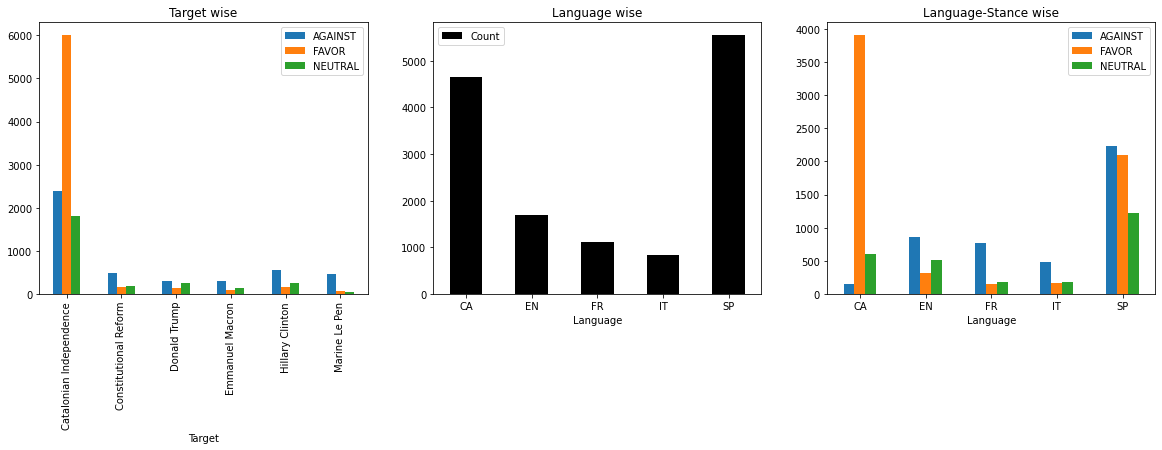

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,5))

data_frq1.plot(x='Target', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[0], title='Target wise')
data_frq2.plot(x='Language', kind='bar', ax=axes[1], title='Language wise', color='black')
data_frq3.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[2], title='Language-Stance wise')
axes[1].tick_params(axis='x', labelrotation=360)
axes[2].tick_params(axis='x', labelrotation=360)

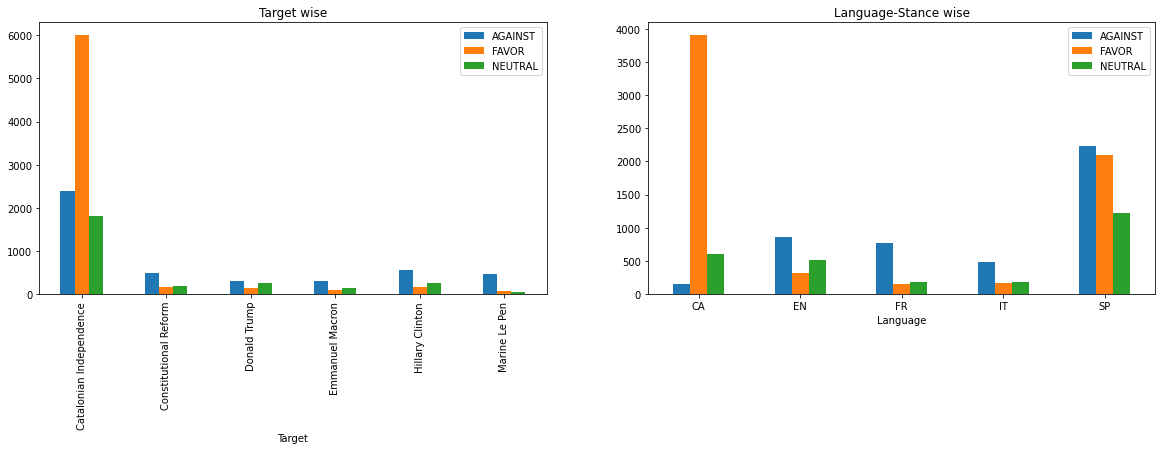

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,5))

data_frq1.plot(x='Target', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[0], title='Target wise')
data_frq3.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[1], title='Language-Stance wise')
axes[1].tick_params(axis='x', labelrotation=360)

total number of records 1691
Stance bifurcation Counter({'AGAINST': 864, 'NEUTRAL': 516, 'FAVOR': 311})
            Target Language  AGAINST  FAVOR  NEUTRAL
0     Donald Trump       EN      299    148      260
1  Hillary Clinton       EN      565    163      256


total number of records 1691
Stance bifurcation Counter({'AGAINST': 864, 'NEUTRAL': 516, 'FAVOR': 311})
            Target  AGAINST  FAVOR  NEUTRAL
0     Donald Trump      299    148      260
1  Hillary Clinton      565    163      256




(array([0, 1]), <a list of 2 Text major ticklabel objects>)

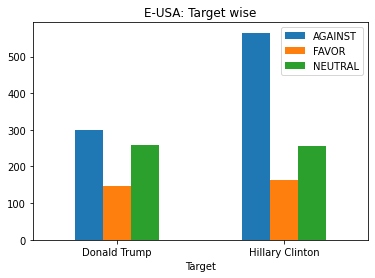

In [ ]:
print('total number of records', len(data1))
data_label = collections.Counter(data1['Stance'])
print('Stance bifurcation', data_label)

data_frq2 = data1.groupby(['Target','Language','Stance']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})

data_frq2= pd.pivot_table(data=data_frq2 , index=['Target','Language'], columns=['Stance'],values=['Count'])
data_frq2.reset_index(inplace=True)
data_frq2.columns =['Target','Language','AGAINST','FAVOR','NEUTRAL']
print(data_frq2)

print("\n")

print('total number of records', len(data1))
data_label = collections.Counter(data1['Stance'])
print('Stance bifurcation', data_label)

data_frq2 = data1.groupby(['Target','Stance']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})

data_frq2= pd.pivot_table(data=data_frq2 , index=['Target'], columns=['Stance'],values=['Count'])
data_frq2.reset_index(inplace=True)
data_frq2.columns =['Target','AGAINST','FAVOR','NEUTRAL']
print(data_frq2)

print("\n")

data_frq2.plot(x='Target', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar',title='E-USA: Target wise')
plt.xticks(rotation=360)

total number of records 1691
Stance bifurcation Counter({'AGAINST': 864, 'NEUTRAL': 516, 'FAVOR': 311})
  Language  AGAINST  FAVOR  NEUTRAL
0       EN      864    311      516




(array([0]), <a list of 1 Text major ticklabel objects>)

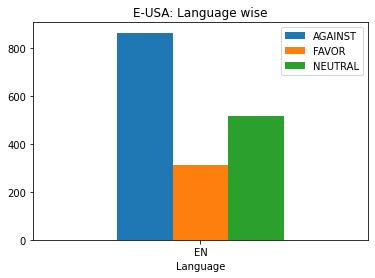

In [ ]:
print('total number of records', len(data1))
data_label = collections.Counter(data1['Stance'])
print('Stance bifurcation', data_label)

data_frq2 = data1.groupby(['Language','Stance']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})

data_frq2= pd.pivot_table(data=data_frq2 , index=['Language'], columns=['Stance'],values=['Count'])
data_frq2.reset_index(inplace=True)
data_frq2.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(data_frq2)

print("\n")

data_frq2.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar',title='E-USA: Language wise')
plt.xticks(rotation=360)

total number of records 10194
Stance bifurcation Counter({'FAVOR': 6001, 'AGAINST': 2380, 'NEUTRAL': 1813})
                    Target Language  AGAINST  FAVOR  NEUTRAL
0  Catalonian Independence       CA      149   3902      598
1  Catalonian Independence       SP     2231   2099     1215


total number of records 10194
Stance bifurcation Counter({'FAVOR': 6001, 'AGAINST': 2380, 'NEUTRAL': 1813})
                    Target  AGAINST  FAVOR  NEUTRAL
0  Catalonian Independence     2380   6001     1813


total number of records 10194
Stance bifurcation Counter({'FAVOR': 6001, 'AGAINST': 2380, 'NEUTRAL': 1813})
  Language  AGAINST  FAVOR  NEUTRAL
0       CA      149   3902      598
1       SP     2231   2099     1215




(array([0, 1]), <a list of 2 Text major ticklabel objects>)

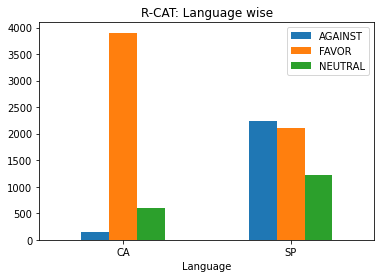

In [ ]:
print('total number of records', len(data2))
data_label = collections.Counter(data2['Stance'])
print('Stance bifurcation', data_label)

data_frq2 = data2.groupby(['Target','Language','Stance']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})

data_frq2= pd.pivot_table(data=data_frq2 , index=['Target','Language'], columns=['Stance'],values=['Count'])
data_frq2.reset_index(inplace=True)
data_frq2.columns =['Target','Language','AGAINST','FAVOR','NEUTRAL']
print(data_frq2)

print("\n")

print('total number of records', len(data2))
data_label = collections.Counter(data2['Stance'])
print('Stance bifurcation', data_label)

data_frq2 = data2.groupby(['Target','Stance']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})

data_frq2= pd.pivot_table(data=data_frq2 , index=['Target'], columns=['Stance'],values=['Count'])
data_frq2.reset_index(inplace=True)
data_frq2.columns =['Target','AGAINST','FAVOR','NEUTRAL']
print(data_frq2)

print("\n")

print('total number of records', len(data2))
data_label = collections.Counter(data2['Stance'])
print('Stance bifurcation', data_label)

data_frq2 = data2.groupby(['Language','Stance']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})

data_frq2= pd.pivot_table(data=data_frq2 , index=['Language'], columns=['Stance'],values=['Count'])
data_frq2.reset_index(inplace=True)
data_frq2.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(data_frq2)

print("\n")
data_frq2.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar',title='R-CAT: Language wise')
plt.xticks(rotation=360)

total number of records 10194
Stance bifurcation Counter({'FAVOR': 6001, 'AGAINST': 2380, 'NEUTRAL': 1813})
                    Target  AGAINST  FAVOR  NEUTRAL
0  Catalonian Independence     2380   6001     1813




(array([0]), <a list of 1 Text major ticklabel objects>)

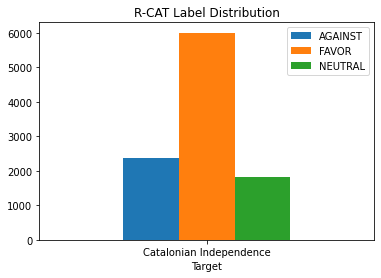

In [ ]:
print('total number of records', len(data2))
data_label = collections.Counter(data2['Stance'])
print('Stance bifurcation', data_label)

data_frq2 = data2.groupby(['Target','Stance']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})

data_frq2= pd.pivot_table(data=data_frq2 , index=['Target'], columns=['Stance'],values=['Count'])
data_frq2.reset_index(inplace=True)
data_frq2.columns =['Target','AGAINST','FAVOR','NEUTRAL']
print(data_frq2)

print("\n")
data_frq2.plot(x='Target', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar',title='R-CAT Label Distribution')
plt.xticks(rotation=360)

total number of records 1116
Stance bifurcation Counter({'AGAINST': 774, 'NEUTRAL': 186, 'FAVOR': 156})
            Target  AGAINST  FAVOR  NEUTRAL
0  Emmanuel Macron      308     91      131
1    Marine Le Pen      466     65       55




(array([0, 1]), <a list of 2 Text major ticklabel objects>)

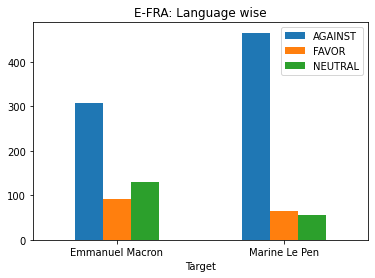

In [ ]:
print('total number of records', len(data3))
data_label = collections.Counter(data3['Stance'])
print('Stance bifurcation', data_label)

data_frq2 = data3.groupby(['Target','Stance']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})

data_frq2= pd.pivot_table(data=data_frq2 , index=['Target'], columns=['Stance'],values=['Count'])
data_frq2.reset_index(inplace=True)
data_frq2.columns =['Target','AGAINST','FAVOR','NEUTRAL']
print(data_frq2)

print("\n")
data_frq2.plot(x='Target', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar',title='E-FRA: Language wise')
plt.xticks(rotation=360)

total number of records 833
Stance bifurcation Counter({'AGAINST': 486, 'NEUTRAL': 184, 'FAVOR': 163})
                  Target  AGAINST  FAVOR  NEUTRAL
0  Constitutional Reform      486    163      184




(array([0]), <a list of 1 Text major ticklabel objects>)

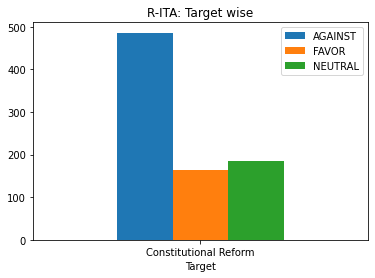

In [ ]:
print('total number of records', len(data4))
data_label = collections.Counter(data4['Stance'])
print('Stance bifurcation', data_label)

data_frq2 = data4.groupby(['Target','Stance']).size().reset_index()
data_frq2=data_frq2.rename(columns={0:'Count'})

data_frq2= pd.pivot_table(data=data_frq2 , index=['Target'], columns=['Stance'],values=['Count'])
data_frq2.reset_index(inplace=True)
data_frq2.columns =['Target','AGAINST','FAVOR','NEUTRAL']
print(data_frq2)

print("\n")

data_frq2.plot(x='Target', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar',title='R-ITA: Target wise')
plt.xticks(rotation=360)

# Train/Validation/Test Data split

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
sp_against = data.loc[(data['Stance']=='AGAINST') & (data['Language']=='SP')]
sp_neutral = data.loc[(data['Stance']=='NEUTRAL') & (data['Language']=='SP')]
sp_favor = data.loc[(data['Stance']=='FAVOR') & (data['Language']=='SP')]
ca_against = data.loc[(data['Stance']=='AGAINST') & (data['Language']=='CA')]
ca_neutral = data.loc[(data['Stance']=='NEUTRAL') & (data['Language']=='CA')]
ca_favor = data.loc[(data['Stance']=='FAVOR') & (data['Language']=='CA')]
en_against = data.loc[(data['Stance']=='AGAINST') & (data['Language']=='EN')]
en_neutral = data.loc[(data['Stance']=='NEUTRAL') & (data['Language']=='EN')]
en_favor = data.loc[(data['Stance']=='FAVOR') & (data['Language']=='EN')]
fr_against = data.loc[(data['Stance']=='AGAINST') & (data['Language']=='FR')]
fr_neutral = data.loc[(data['Stance']=='NEUTRAL') & (data['Language']=='FR')]
fr_favor = data.loc[(data['Stance']=='FAVOR') & (data['Language']=='FR')]
it_against = data.loc[(data['Stance']=='AGAINST') & (data['Language']=='IT')]
it_neutral = data.loc[(data['Stance']=='NEUTRAL') & (data['Language']=='IT')]
it_favor = data.loc[(data['Stance']=='FAVOR') & (data['Language']=='IT')]

train1, test1 = train_test_split(sp_against, test_size=0.2)
train2, test2 = train_test_split(sp_neutral, test_size=0.2)
train3, test3 = train_test_split(sp_favor, test_size=0.2)
train4, test4 = train_test_split(ca_against, test_size=0.2)
train5, test5 = train_test_split(ca_neutral, test_size=0.2)
train6, test6 = train_test_split(ca_favor, test_size=0.2)
train7, test7 = train_test_split(en_against, test_size=0.2)
train8, test8 = train_test_split(en_neutral, test_size=0.2)
train9, test9 = train_test_split(en_favor, test_size=0.2)
train10, test10 = train_test_split(fr_against, test_size=0.2)
train11, test11 = train_test_split(fr_neutral, test_size=0.2)
train12, test12 = train_test_split(fr_favor, test_size=0.2)
train13, test13 = train_test_split(it_against, test_size=0.2)
train14, test14 = train_test_split(it_neutral, test_size=0.2)
train15, test15 = train_test_split(it_favor, test_size=0.2)

frames=[train1,train2,train3,train4,train5,train6,train7,train8,train9,train10,train11,train12,train13,train14,train15]
train = pd.concat(frames)
print("Train Data", collections.Counter(train['Stance']))

frames=[test1,test2,test3,test4,test5,test6,test7,test8,test9,test10,test11,test12,test13,test14,test15]
test = pd.concat(frames)
print("test Data", collections.Counter(test['Stance']))

Train Data Counter({'FAVOR': 5302, 'AGAINST': 3601, 'NEUTRAL': 2157})
test Data Counter({'FAVOR': 1329, 'AGAINST': 903, 'NEUTRAL': 542})


In [ ]:
sp_against = train.loc[(train['Stance']=='AGAINST') & (train['Language']=='SP')]
sp_neutral = train.loc[(train['Stance']=='NEUTRAL') & (train['Language']=='SP')]
sp_favor = train.loc[(train['Stance']=='FAVOR') & (train['Language']=='SP')]
ca_against = train.loc[(train['Stance']=='AGAINST') & (train['Language']=='CA')]
ca_neutral = train.loc[(train['Stance']=='NEUTRAL') & (train['Language']=='CA')]
ca_favor = train.loc[(train['Stance']=='FAVOR') & (train['Language']=='CA')]
en_against = train.loc[(train['Stance']=='AGAINST') & (train['Language']=='EN')]
en_neutral = train.loc[(train['Stance']=='NEUTRAL') & (train['Language']=='EN')]
en_favor = train.loc[(train['Stance']=='FAVOR') & (train['Language']=='EN')]
fr_against = train.loc[(train['Stance']=='AGAINST') & (train['Language']=='FR')]
fr_neutral = train.loc[(train['Stance']=='NEUTRAL') & (train['Language']=='FR')]
fr_favor = train.loc[(train['Stance']=='FAVOR') & (train['Language']=='FR')]
it_against = train.loc[(train['Stance']=='AGAINST') & (train['Language']=='IT')]
it_neutral = train.loc[(train['Stance']=='NEUTRAL') & (train['Language']=='IT')]
it_favor = train.loc[(train['Stance']=='FAVOR') & (train['Language']=='IT')]

train1, val1 = train_test_split(sp_against, test_size=0.25)
train2, val2 = train_test_split(sp_neutral, test_size=0.25)
train3, val3 = train_test_split(sp_favor, test_size=0.25)
train4, val4 = train_test_split(ca_against, test_size=0.25)
train5, val5 = train_test_split(ca_neutral, test_size=0.25)
train6, val6 = train_test_split(ca_favor, test_size=0.25)
train7, val7 = train_test_split(en_against, test_size=0.25)
train8, val8 = train_test_split(en_neutral, test_size=0.25)
train9, val9 = train_test_split(en_favor, test_size=0.25)
train10, val10 = train_test_split(fr_against, test_size=0.25)
train11, val11 = train_test_split(fr_neutral, test_size=0.25)
train12, val12 = train_test_split(fr_favor, test_size=0.25)
train13, val13 = train_test_split(it_against, test_size=0.25)
train14, val14 = train_test_split(it_neutral, test_size=0.25)
train15, val15 = train_test_split(it_favor, test_size=0.25)

frames=[train1,train2,train3,train4,train5,train6,train7,train8,train9,train10,train11,train12,train13,train14,train15]
train = pd.concat(frames)
print("Train Data", collections.Counter(train['Stance']))

frames=[val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,val11,val12,val13,val14,val15]
val = pd.concat(frames)
print("val Data", collections.Counter(val['Stance']))

Train Data Counter({'FAVOR': 3975, 'AGAINST': 2700, 'NEUTRAL': 1617})
val Data Counter({'FAVOR': 1327, 'AGAINST': 901, 'NEUTRAL': 540})


In [ ]:
print ( "training set contains %d number of tweets" % len(train))
print ( "validation set contains %d number of tweets" % len(val))
print ( "test set contains %d number of tweets" % len(test))

print("Train Data", collections.Counter(train['Stance']))
print("Validation Data", collections.Counter(val['Stance']))
print("Test Data", collections.Counter(test['Stance']))

training set contains 8292 number of tweets
validation set contains 2768 number of tweets
test set contains 2774 number of tweets
Train Data Counter({'FAVOR': 3975, 'AGAINST': 2700, 'NEUTRAL': 1617})
Validation Data Counter({'FAVOR': 1327, 'AGAINST': 901, 'NEUTRAL': 540})
Test Data Counter({'FAVOR': 1329, 'AGAINST': 903, 'NEUTRAL': 542})


8292
11060


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

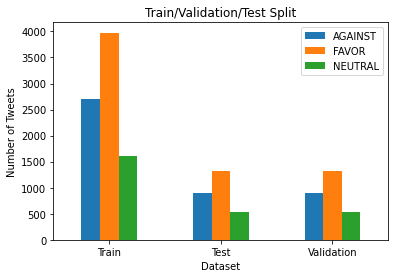

In [ ]:
temp = train
temp['Dataset'] ='Train'
print(len(temp))

frame =[temp,val]
temp=pd.concat(frame)
print(len(temp))
temp.loc[temp['Dataset'].isnull(),'Dataset']='Validation'

frame =[temp,test]
temp=pd.concat(frame)
temp.loc[temp['Dataset'].isnull(),'Dataset']='Test'

temp_frq = temp.groupby(['Dataset','Stance']).size().reset_index()
temp_frq=temp_frq.rename(columns={0:'Count'})

temp_frq= pd.pivot_table(data=temp_frq , index=['Dataset'], columns=['Stance'],values=['Count'])
temp_frq.reset_index(inplace=True)
temp_frq.columns =['Dataset','AGAINST','FAVOR','NEUTRAL']
temp_frq = temp_frq.sort_values(by=['AGAINST'], ascending=False)

temp_frq.plot(x='Dataset', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', title='Train/Validation/Test Split', ylabel='Number of Tweets')
plt.xticks(rotation=360)

In [ ]:
print('total number of records', len(train))
train_label = collections.Counter(train['Stance'])
print('Stance bifurcation', train_label)

train_frq = train.groupby(['Language','Stance']).size().reset_index()
train_frq=train_frq.rename(columns={0:'Count'})

train_frq= pd.pivot_table(data=train_frq , index=['Language'], columns=['Stance'],values=['Count'])
train_frq.reset_index(inplace=True)
train_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(train_frq)

print('total number of records', len(val))
val_label = collections.Counter(val['Stance'])
print('Stance bifurcation', val_label)

val_frq = val.groupby(['Language','Stance']).size().reset_index()
val_frq=val_frq.rename(columns={0:'Count'})

val_frq= pd.pivot_table(data=val_frq , index=['Language'], columns=['Stance'],values=['Count'])
val_frq.reset_index(inplace=True)
val_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(val_frq)

print('total number of records', len(test))
test_label = collections.Counter(test['Stance'])
print('Stance bifurcation', test_label)

test_frq = test.groupby(['Language','Stance']).size().reset_index()
test_frq=test_frq.rename(columns={0:'Count'})

test_frq= pd.pivot_table(data=test_frq , index=['Language'], columns=['Stance'],values=['Count'])
test_frq.reset_index(inplace=True)
test_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(test_frq)

total number of records 8292
Stance bifurcation Counter({'FAVOR': 3975, 'AGAINST': 2700, 'NEUTRAL': 1617})
  Language  AGAINST  FAVOR  NEUTRAL
0       CA       89   2340      358
1       EN      518    186      309
2       FR      464     93      111
3       IT      291     97      110
4       SP     1338   1259      729
total number of records 2768
Stance bifurcation Counter({'FAVOR': 1327, 'AGAINST': 901, 'NEUTRAL': 540})
  Language  AGAINST  FAVOR  NEUTRAL
0       CA       30    781      120
1       EN      173     62      103
2       FR      155     31       37
3       IT       97     33       37
4       SP      446    420      243
total number of records 2774
Stance bifurcation Counter({'FAVOR': 1329, 'AGAINST': 903, 'NEUTRAL': 542})
  Language  AGAINST  FAVOR  NEUTRAL
0       CA       30    781      120
1       EN      173     63      104
2       FR      155     32       38
3       IT       98     33       37
4       SP      447    420      243


# Unbalanced Trainset

In [ ]:
train_fr = train.loc[train['Language']=='FR']
print("French Training set contains ", len(train_fr))
train_en = train.loc[train['Language']=='EN']
print("English Training set contains ", len(train_en))
train_sp = train.loc[train['Language']=='SP']
print("Spanish Training set contains ", len(train_sp))
train_ca = train.loc[train['Language']=='CA']
print("Catalan Training set contains ", len(train_ca))
train_it = train.loc[train['Language']=='IT']
print("Italian Training set contains ", len(train_it))

val_fr = val.loc[val['Language']=='FR']
print("French Validation set contains ", len(val_fr))
val_en = val.loc[val['Language']=='EN']
print("English Validation set contains ", len(val_en))
val_sp = val.loc[val['Language']=='SP']
print("Spanish Validation set contains ", len(val_sp))
val_ca = val.loc[val['Language']=='CA']
print("Catalan Validation set contains ", len(val_ca))
val_it = val.loc[val['Language']=='IT']
print("Italian Validation set contains ", len(val_it))

test_fr = test.loc[test['Language']=='FR']
print("French Test set contains ", len(test_fr))
test_en = test.loc[test['Language']=='EN']
print("English Test set contains ", len(test_en))
test_sp = test.loc[test['Language']=='SP']
print("Spanish Test set contains ", len(test_sp))
test_ca = test.loc[test['Language']=='CA']
print("Catalan Test set contains ", len(test_ca))
test_it = test.loc[test['Language']=='IT']
print("Italian Test set contains ", len(test_it))

French Training set contains  668
English Training set contains  1013
Spanish Training set contains  3326
Catalan Training set contains  2787
Italian Training set contains  498
French Validation set contains  223
English Validation set contains  338
Spanish Validation set contains  1109
Catalan Validation set contains  931
Italian Validation set contains  167
French Test set contains  225
English Test set contains  340
Spanish Test set contains  1110
Catalan Test set contains  931
Italian Test set contains  168


total number of records 3326
Stance bifurcation Counter({'AGAINST': 1338, 'FAVOR': 1259, 'NEUTRAL': 729})
  Language  AGAINST  FAVOR  NEUTRAL
0       SP     1338   1259      729
total number of records 1109
Stance bifurcation Counter({'AGAINST': 446, 'FAVOR': 420, 'NEUTRAL': 243})
  Language  AGAINST  FAVOR  NEUTRAL
0       SP      446    420      243
total number of records 1110
Stance bifurcation Counter({'AGAINST': 447, 'FAVOR': 420, 'NEUTRAL': 243})
  Language  AGAINST  FAVOR  NEUTRAL
0       SP      447    420      243


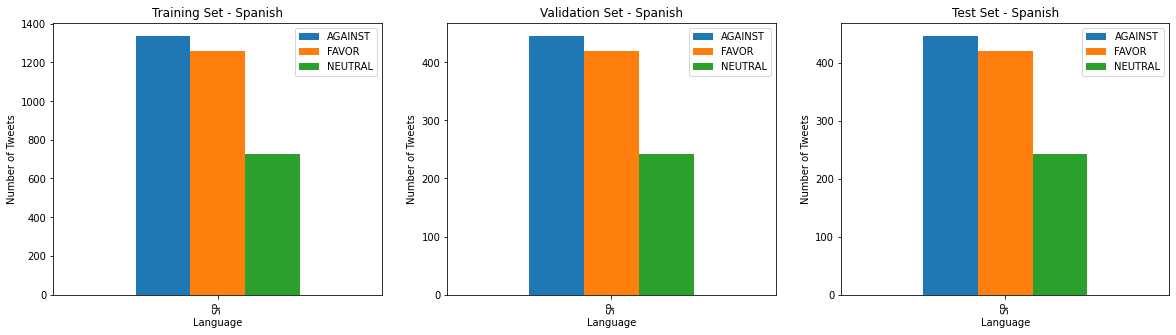

In [ ]:
print('total number of records', len(train_sp))
train_label = collections.Counter(train_sp['Stance'])
print('Stance bifurcation', train_label)

train_frq = train_sp.groupby(['Language','Stance']).size().reset_index()
train_frq=train_frq.rename(columns={0:'Count'})

train_frq= pd.pivot_table(data=train_frq , index=['Language'], columns=['Stance'],values=['Count'])
train_frq.reset_index(inplace=True)
train_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(train_frq)

print('total number of records', len(val_sp))
val_label = collections.Counter(val_sp['Stance'])
print('Stance bifurcation', val_label)

val_frq = val_sp.groupby(['Language','Stance']).size().reset_index()
val_frq=val_frq.rename(columns={0:'Count'})

val_frq= pd.pivot_table(data=val_frq , index=['Language'], columns=['Stance'],values=['Count'])
val_frq.reset_index(inplace=True)
val_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(val_frq)

print('total number of records', len(test_sp))
test_label = collections.Counter(test_sp['Stance'])
print('Stance bifurcation', test_label)

test_frq = test_sp.groupby(['Language','Stance']).size().reset_index()
test_frq=test_frq.rename(columns={0:'Count'})

test_frq= pd.pivot_table(data=test_frq , index=['Language'], columns=['Stance'],values=['Count'])
test_frq.reset_index(inplace=True)
test_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(test_frq)

fig, axes = plt.subplots(1,3, figsize=(20,5))

train_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[0], title='Training Set - Spanish', ylabel='Number of Tweets')
val_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[1], title='Validation Set - Spanish', ylabel='Number of Tweets')
test_frq.plot(x="Language", y=["AGAINST", "FAVOR",'NEUTRAL'], kind="bar", ax=axes[2], title='Test Set - Spanish', ylabel='Number of Tweets')

total number of records 1013
Stance bifurcation Counter({'AGAINST': 518, 'NEUTRAL': 309, 'FAVOR': 186})
  Language  AGAINST  FAVOR  NEUTRAL
0       EN      518    186      309
total number of records 338
Stance bifurcation Counter({'AGAINST': 173, 'NEUTRAL': 103, 'FAVOR': 62})
  Language  AGAINST  FAVOR  NEUTRAL
0       EN      173     62      103
total number of records 340
Stance bifurcation Counter({'AGAINST': 173, 'NEUTRAL': 104, 'FAVOR': 63})
  Language  AGAINST  FAVOR  NEUTRAL
0       EN      173     63      104


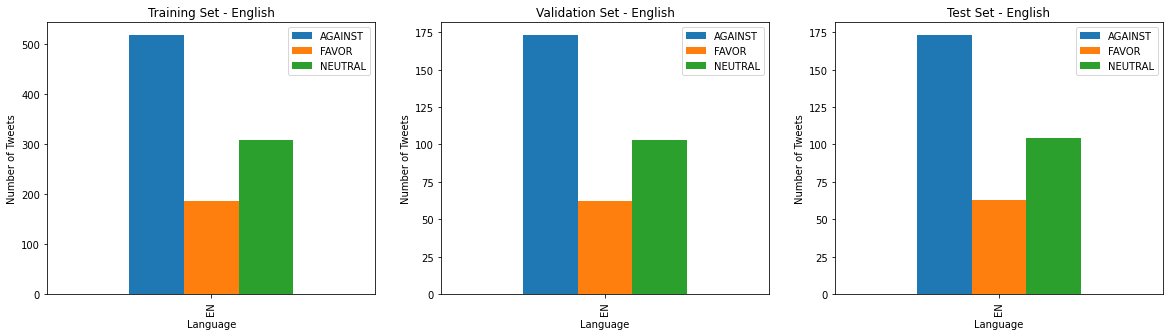

In [ ]:
print('total number of records', len(train_en))
train_label = collections.Counter(train_en['Stance'])
print('Stance bifurcation', train_label)

train_frq = train_en.groupby(['Language','Stance']).size().reset_index()
train_frq=train_frq.rename(columns={0:'Count'})

train_frq= pd.pivot_table(data=train_frq , index=['Language'], columns=['Stance'],values=['Count'])
train_frq.reset_index(inplace=True)
train_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(train_frq)

print('total number of records', len(val_en))
val_label = collections.Counter(val_en['Stance'])
print('Stance bifurcation', val_label)

val_frq = val_en.groupby(['Language','Stance']).size().reset_index()
val_frq=val_frq.rename(columns={0:'Count'})

val_frq= pd.pivot_table(data=val_frq , index=['Language'], columns=['Stance'],values=['Count'])
val_frq.reset_index(inplace=True)
val_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(val_frq)

print('total number of records', len(test_en))
test_label = collections.Counter(test_en['Stance'])
print('Stance bifurcation', test_label)

test_frq = test_en.groupby(['Language','Stance']).size().reset_index()
test_frq=test_frq.rename(columns={0:'Count'})

test_frq= pd.pivot_table(data=test_frq , index=['Language'], columns=['Stance'],values=['Count'])
test_frq.reset_index(inplace=True)
test_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(test_frq)

fig, axes = plt.subplots(1,3, figsize=(20,5))

train_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[0], title='Training Set - English', ylabel='Number of Tweets')
val_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[1], title='Validation Set - English', ylabel='Number of Tweets')
test_frq.plot(x="Language", y=["AGAINST", "FAVOR",'NEUTRAL'], kind="bar", ax=axes[2], title='Test Set - English', ylabel='Number of Tweets')

total number of records 2787
Stance bifurcation Counter({'FAVOR': 2340, 'NEUTRAL': 358, 'AGAINST': 89})
  Language  AGAINST  FAVOR  NEUTRAL
0       CA       89   2340      358
total number of records 931
Stance bifurcation Counter({'FAVOR': 781, 'NEUTRAL': 120, 'AGAINST': 30})
  Language  AGAINST  FAVOR  NEUTRAL
0       CA       30    781      120
total number of records 931
Stance bifurcation Counter({'FAVOR': 781, 'NEUTRAL': 120, 'AGAINST': 30})
  Language  AGAINST  FAVOR  NEUTRAL
0       CA       30    781      120


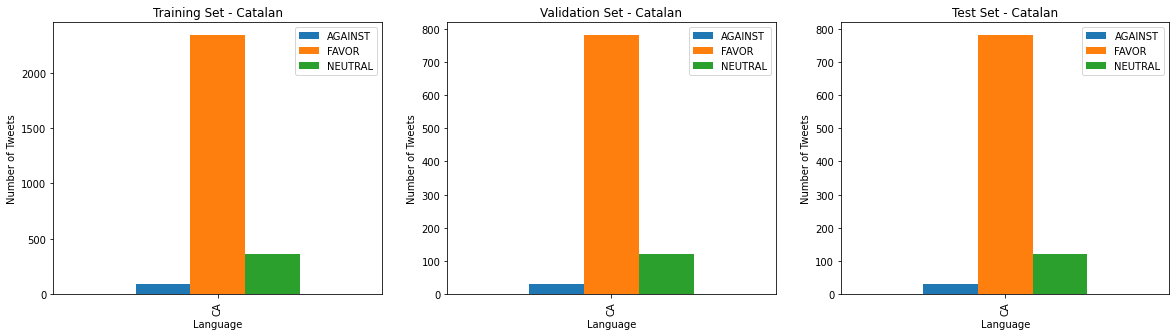

In [ ]:
print('total number of records', len(train_ca))
train_label = collections.Counter(train_ca['Stance'])
print('Stance bifurcation', train_label)

train_frq = train_ca.groupby(['Language','Stance']).size().reset_index()
train_frq=train_frq.rename(columns={0:'Count'})

train_frq= pd.pivot_table(data=train_frq , index=['Language'], columns=['Stance'],values=['Count'])
train_frq.reset_index(inplace=True)
train_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(train_frq)

print('total number of records', len(val_ca))
val_label = collections.Counter(val_ca['Stance'])
print('Stance bifurcation', val_label)

val_frq = val_ca.groupby(['Language','Stance']).size().reset_index()
val_frq=val_frq.rename(columns={0:'Count'})

val_frq= pd.pivot_table(data=val_frq , index=['Language'], columns=['Stance'],values=['Count'])
val_frq.reset_index(inplace=True)
val_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(val_frq)

print('total number of records', len(test_ca))
test_label = collections.Counter(test_ca['Stance'])
print('Stance bifurcation', test_label)

test_frq = test_ca.groupby(['Language','Stance']).size().reset_index()
test_frq=test_frq.rename(columns={0:'Count'})

test_frq= pd.pivot_table(data=test_frq , index=['Language'], columns=['Stance'],values=['Count'])
test_frq.reset_index(inplace=True)
test_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(test_frq)

fig, axes = plt.subplots(1,3, figsize=(20,5))

train_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[0], title='Training Set - Catalan', ylabel='Number of Tweets')
val_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[1], title='Validation Set - Catalan', ylabel='Number of Tweets')
test_frq.plot(x="Language", y=["AGAINST", "FAVOR",'NEUTRAL'], kind="bar", ax=axes[2], title='Test Set - Catalan', ylabel='Number of Tweets')

total number of records 668
Stance bifurcation Counter({'AGAINST': 464, 'NEUTRAL': 111, 'FAVOR': 93})
  Language  AGAINST  FAVOR  NEUTRAL
0       FR      464     93      111
total number of records 223
Stance bifurcation Counter({'AGAINST': 155, 'NEUTRAL': 37, 'FAVOR': 31})
  Language  AGAINST  FAVOR  NEUTRAL
0       FR      155     31       37
total number of records 225
Stance bifurcation Counter({'AGAINST': 155, 'NEUTRAL': 38, 'FAVOR': 32})
  Language  AGAINST  FAVOR  NEUTRAL
0       FR      155     32       38


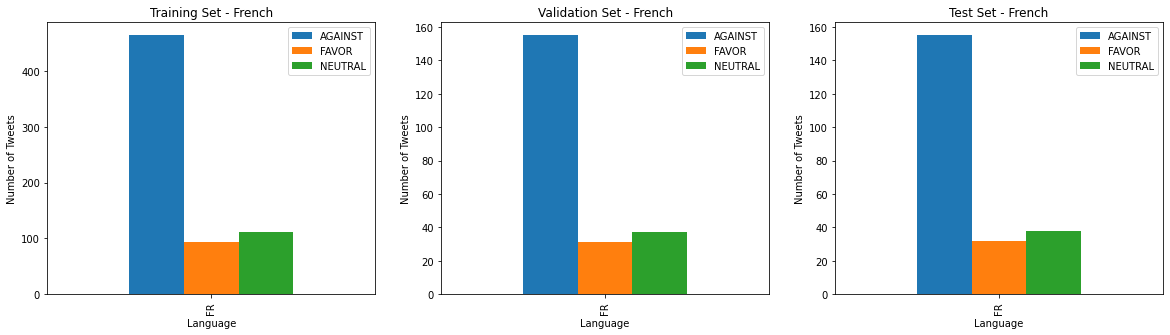

In [ ]:
print('total number of records', len(train_fr))
train_label = collections.Counter(train_fr['Stance'])
print('Stance bifurcation', train_label)

train_frq = train_fr.groupby(['Language','Stance']).size().reset_index()
train_frq=train_frq.rename(columns={0:'Count'})

train_frq= pd.pivot_table(data=train_frq , index=['Language'], columns=['Stance'],values=['Count'])
train_frq.reset_index(inplace=True)
train_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(train_frq)

print('total number of records', len(val_fr))
val_label = collections.Counter(val_fr['Stance'])
print('Stance bifurcation', val_label)

val_frq = val_fr.groupby(['Language','Stance']).size().reset_index()
val_frq=val_frq.rename(columns={0:'Count'})

val_frq= pd.pivot_table(data=val_frq , index=['Language'], columns=['Stance'],values=['Count'])
val_frq.reset_index(inplace=True)
val_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(val_frq)

print('total number of records', len(test_fr))
test_label = collections.Counter(test_fr['Stance'])
print('Stance bifurcation', test_label)

test_frq = test_fr.groupby(['Language','Stance']).size().reset_index()
test_frq=test_frq.rename(columns={0:'Count'})

test_frq= pd.pivot_table(data=test_frq , index=['Language'], columns=['Stance'],values=['Count'])
test_frq.reset_index(inplace=True)
test_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(test_frq)

fig, axes = plt.subplots(1,3, figsize=(20,5))

train_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[0], title='Training Set - French', ylabel='Number of Tweets')
val_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[1], title='Validation Set - French', ylabel='Number of Tweets')
test_frq.plot(x="Language", y=["AGAINST", "FAVOR",'NEUTRAL'], kind="bar", ax=axes[2], title='Test Set - French', ylabel='Number of Tweets')

total number of records 498
Stance bifurcation Counter({'AGAINST': 291, 'NEUTRAL': 110, 'FAVOR': 97})
  Language  AGAINST  FAVOR  NEUTRAL
0       IT      291     97      110
total number of records 167
Stance bifurcation Counter({'AGAINST': 97, 'NEUTRAL': 37, 'FAVOR': 33})
  Language  AGAINST  FAVOR  NEUTRAL
0       IT       97     33       37
total number of records 168
Stance bifurcation Counter({'AGAINST': 98, 'NEUTRAL': 37, 'FAVOR': 33})
  Language  AGAINST  FAVOR  NEUTRAL
0       IT       98     33       37


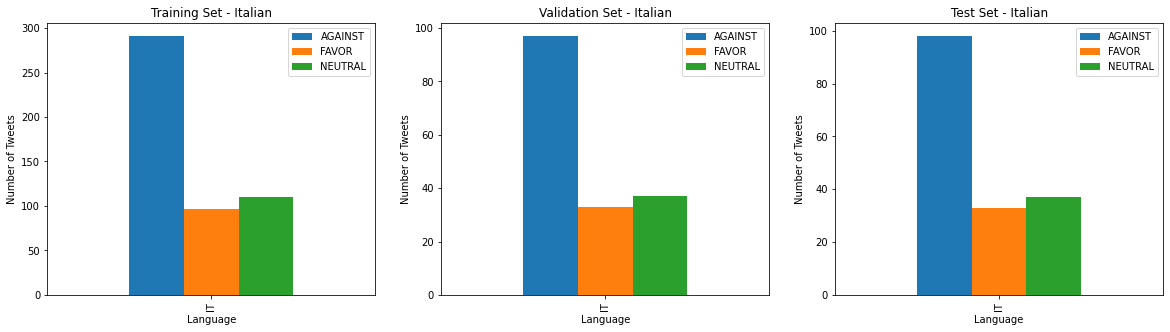

In [ ]:
print('total number of records', len(train_it))
train_label = collections.Counter(train_it['Stance'])
print('Stance bifurcation', train_label)

train_frq = train_it.groupby(['Language','Stance']).size().reset_index()
train_frq=train_frq.rename(columns={0:'Count'})

train_frq= pd.pivot_table(data=train_frq , index=['Language'], columns=['Stance'],values=['Count'])
train_frq.reset_index(inplace=True)
train_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(train_frq)

print('total number of records', len(val_it))
val_label = collections.Counter(val_it['Stance'])
print('Stance bifurcation', val_label)

val_frq = val_it.groupby(['Language','Stance']).size().reset_index()
val_frq=val_frq.rename(columns={0:'Count'})

val_frq= pd.pivot_table(data=val_frq , index=['Language'], columns=['Stance'],values=['Count'])
val_frq.reset_index(inplace=True)
val_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(val_frq)

print('total number of records', len(test_it))
test_label = collections.Counter(test_it['Stance'])
print('Stance bifurcation', test_label)

test_frq = test_it.groupby(['Language','Stance']).size().reset_index()
test_frq=test_frq.rename(columns={0:'Count'})

test_frq= pd.pivot_table(data=test_frq , index=['Language'], columns=['Stance'],values=['Count'])
test_frq.reset_index(inplace=True)
test_frq.columns =['Language','AGAINST','FAVOR','NEUTRAL']
print(test_frq)

fig, axes = plt.subplots(1,3, figsize=(20,5))

train_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[0], title='Training Set - Italian', ylabel='Number of Tweets')
val_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[1], title='Validation Set - Italian', ylabel='Number of Tweets')
test_frq.plot(x="Language", y=["AGAINST", "FAVOR",'NEUTRAL'], kind="bar", ax=axes[2], title='Test Set - Italian', ylabel='Number of Tweets')

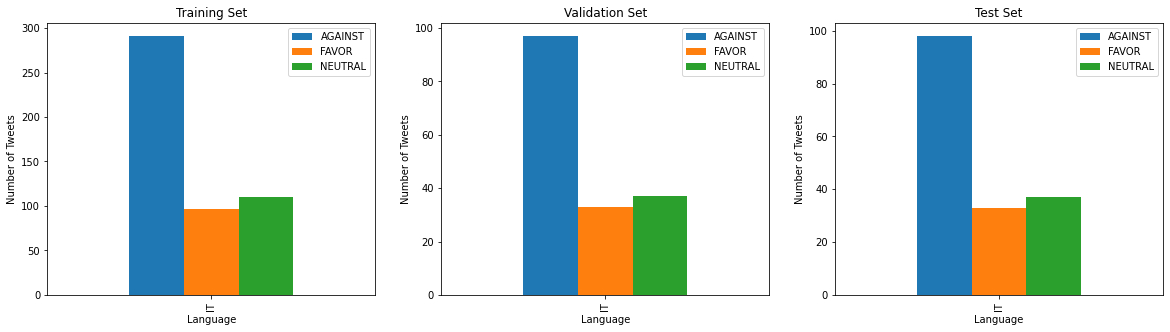

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,5))

train_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[0], title='Training Set', ylabel='Number of Tweets')
val_frq.plot(x='Language', y=['AGAINST','FAVOR','NEUTRAL'], kind='bar', ax=axes[1], title='Validation Set', ylabel='Number of Tweets')
test_frq.plot(x="Language", y=["AGAINST", "FAVOR",'NEUTRAL'], kind="bar", ax=axes[2], title='Test Set', ylabel='Number of Tweets')